In [3]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [4]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)
device

cpu


/home/anton/miniconda3/envs/cadd/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673752754831/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [5]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")

In [6]:
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

In [8]:
fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(data["smiles"][0]), 2, nBits=2048)

In [9]:
# fp to numpy array
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, arr)
arr

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
np.where(arr == 1)

(array([  33,   41,   80,  114,  118,  141,  255,  325,  384,  392,  465,
         650,  655,  656,  699,  807,  843,  862,  875, 1032, 1057, 1088,
        1152, 1199, 1211, 1224, 1233, 1339, 1349, 1357, 1380, 1417, 1580,
        1665, 1685, 1696, 1750, 1756, 1808, 1810, 1816, 1840, 1873, 1917,
        1928, 1948]),)

In [11]:
def get_fingerprint(smiles):
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [12]:
# import counter
from collections import Counter, defaultdict
bits_count = Counter()
for smiles in data["smiles"]:
    fp = get_fingerprint(smiles)
    non_zero = np.where(fp == 1)[0]
    bits_count.update(non_zero)

In [13]:
# sort by id
len(bits_count)

2048

In [24]:
#least common
bits_count.most_common()[-100:]

[(1735, 746),
 (995, 745),
 (513, 745),
 (691, 742),
 (1933, 741),
 (86, 739),
 (712, 739),
 (1716, 735),
 (761, 734),
 (367, 732),
 (435, 732),
 (2015, 721),
 (1044, 719),
 (633, 717),
 (1566, 716),
 (1378, 713),
 (1165, 711),
 (709, 711),
 (1094, 708),
 (331, 706),
 (903, 706),
 (1913, 703),
 (174, 701),
 (1316, 700),
 (1844, 698),
 (1901, 698),
 (1315, 698),
 (572, 697),
 (1271, 688),
 (1674, 688),
 (1838, 686),
 (874, 683),
 (1194, 683),
 (1947, 680),
 (124, 678),
 (340, 667),
 (1335, 665),
 (639, 662),
 (336, 657),
 (2005, 654),
 (439, 650),
 (1981, 646),
 (1748, 644),
 (1737, 643),
 (1558, 638),
 (905, 637),
 (1113, 636),
 (1098, 628),
 (96, 627),
 (1493, 627),
 (644, 625),
 (928, 622),
 (183, 620),
 (669, 616),
 (981, 614),
 (137, 613),
 (1116, 612),
 (566, 593),
 (1421, 593),
 (1037, 590),
 (578, 584),
 (1787, 578),
 (1672, 574),
 (851, 574),
 (1789, 570),
 (414, 569),
 (1857, 565),
 (47, 564),
 (889, 559),
 (416, 550),
 (1902, 550),
 (1772, 542),
 (792, 538),
 (1874, 531),
 (6

In [22]:
bits_count[1990]

6094

In [30]:
total = sum(bits_count.values())
total / len(data) / 2048

0.021929386139910002

In [10]:
sample = data["smiles"][:64]
fp_sample = [get_fingerprint(s) for s in sample]

In [11]:
print(fp_sample[0])

[0. 0. 0. ... 0. 0. 0.]


In [12]:
class SmilesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.smiles = data["smiles"]
    def __len__(self):
        return len(self.smiles)
    def __getitem__(self, idx):
        tensor = torch.from_numpy(get_fingerprint(self.smiles[idx])).float()
        return tensor

In [14]:
dataset = SmilesDataset(data[:249000])
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [16]:
for batch in train_loader:
    print(batch.shape)
    break

torch.Size([64, 2048])


In [75]:
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, latent_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.fc4(x)
        return x
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, with_sigmoid=True):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        if with_sigmoid:
            x = self.sigmoid(self.fc4(x))
        else:
            x = self.fc4(x)
        return x

In [76]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, latent_size, dropout)
        self.decoder = Decoder(latent_size, input_size, dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [87]:
model = Autoencoder(2048, 256, dropout=0.5).to(device)
history = {
    "train_loss": [],
    "valid_loss": []
}

In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
model_name = "fp_autoencoder_drop_50%_2048_256_zinc250k.pt"

In [91]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [90]:
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    print("Model loaded")
else:
    print("Model not found")

Model loaded


In [92]:
from datetime import datetime

epochs = 25
if len(history['valid_loss']) > 0:
    min_val_loss = min(history['valid_loss'])
else:
    min_val_loss = np.inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch.size(0)
    train_loss = train_loss/len(train_loader)
    history["train_loss"].append(train_loss)
    model.eval()
    for batch in valid_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)
        valid_loss += loss.item()*batch.size(0)
    valid_loss = valid_loss/len(valid_loader)
    if valid_loss < min_val_loss:
        torch.save(model.state_dict(), model_name)
        print("Model saved")
        min_val_loss = valid_loss
    history["valid_loss"].append(valid_loss)
    scheduler.step(valid_loss)
    time = datetime.now().strftime(format="%H:%M:%S")
    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}, Current time: {time}" )

Model saved
Epoch: 1 	Training Loss: 4.195001 	Validation Loss: 3.837222, Current time: 17:13:34
Model saved
Epoch: 2 	Training Loss: 4.177860 	Validation Loss: 3.826837, Current time: 17:14:36
Model saved
Epoch: 3 	Training Loss: 4.171316 	Validation Loss: 3.820863, Current time: 17:15:43
Model saved
Epoch: 4 	Training Loss: 4.163963 	Validation Loss: 3.814825, Current time: 17:16:47
Epoch: 5 	Training Loss: 4.157337 	Validation Loss: 3.820234, Current time: 17:17:55
Model saved
Epoch: 6 	Training Loss: 4.152503 	Validation Loss: 3.810274, Current time: 17:19:03
Model saved
Epoch: 7 	Training Loss: 4.161524 	Validation Loss: 3.809066, Current time: 17:20:13
Model saved
Epoch: 8 	Training Loss: 4.166759 	Validation Loss: 3.796839, Current time: 17:21:21
Model saved
Epoch: 9 	Training Loss: 4.149491 	Validation Loss: 3.791330, Current time: 17:22:29
Epoch: 10 	Training Loss: 4.154387 	Validation Loss: 3.794089, Current time: 17:23:36
Model saved
Epoch: 11 	Training Loss: 4.144394 	Valid

KeyboardInterrupt: 

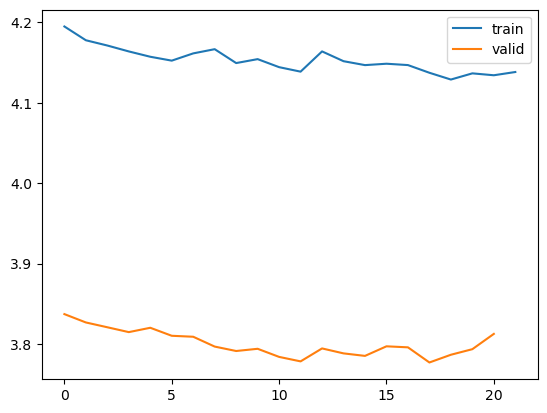

In [93]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["valid_loss"], label="valid")
plt.legend()
plt.show()

In [94]:
diffs = []
total = 0
def compare_fps(fp1, fp2):
    # check which percent of ones from fp1 are in fp2
    fp1 = fp1.astype(int)
    fp2 = fp2.astype(int)
    fp1_idx = np.where(fp1 == 1)[0]
    fp2_idx = np.where(fp2 == 1)[0]
    return len(np.intersect1d(fp1_idx, fp2_idx))/len(fp1_idx)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        output = output > 0.5
        total += len(batch)
        for i in range(len(output)):
            batch_int = batch[i].cpu().detach().numpy().astype(int)
            output_int = output[i].cpu().detach().numpy().astype(int)
            out_idx = np.where(output_int == 1)[0]
            batch_idx = np.where(batch_int == 1)[0]
            # check how many elements from batch are in output
            diff = len(np.intersect1d(batch_idx, out_idx))
            # print(f'Batch: {batch_idx}')
            # print(f'Output: {out_idx}')
            # print(f'Diff: {diff / len(batch_idx)}')
            diffs.append(diff / len(batch_idx))

In [95]:
print(f"Accuracy: {np.mean(diffs):.5f}")

Accuracy: 0.31868


In [96]:
def get_models(model_name):
    model = Autoencoder(2048, 256).to(device)
    model.load_state_dict(torch.load(model_name))
    return model.encoder, model.decoder

In [97]:
encoder, decoder = get_models(model_name)
encoder.eval()
decoder.eval()

Decoder(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [98]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
mdma = get_fingerprint(mdma)
mdma = torch.from_numpy(mdma).float().to(device)
mdma = mdma.unsqueeze(0)

In [99]:
encoded = encoder(mdma)
encoded_bits = encoded.cpu().detach().numpy()
encoded

tensor([[ 3.9701e-01, -7.0493e-01, -2.8345e-01,  2.6018e-01, -6.3072e-01,
         -5.5078e-01,  4.9029e-01,  4.7666e-01, -4.3157e-01,  4.5009e-01,
          3.2387e-01, -7.0446e-01,  2.0406e-01, -4.4866e-01, -6.5338e-01,
         -2.5528e-01,  1.1101e+00,  3.5769e+00,  3.4377e-01,  6.7743e-01,
         -6.2281e-01,  2.1744e-01,  9.3723e-02, -2.1922e-02,  3.8490e-01,
         -2.6063e-02,  2.3185e-01,  3.3129e-01, -6.5617e-01,  6.5869e-01,
         -6.0805e-02, -3.6304e-01,  1.8750e-01,  3.0318e-01,  5.6308e-01,
         -2.7463e-01,  5.0591e-01, -3.4970e+00, -4.6823e-01, -2.2298e-01,
          3.0139e-01, -8.3919e-02,  4.3210e-01, -2.8577e-02,  5.1361e-01,
          1.9367e-01, -3.4790e-01,  1.7137e-01,  1.6148e-01, -3.0136e-01,
         -4.1895e-01, -6.8349e-01, -3.6269e-01, -6.3958e-01,  4.1271e-01,
         -5.9377e-02,  3.2669e-01, -3.3199e-01,  4.3513e-01, -1.2245e-01,
          7.3153e-02, -6.1443e-01, -3.5289e-01, -3.2771e-01, -5.1103e-02,
          4.0561e-02,  1.9321e-01,  5.

In [100]:
decoded = decoder(encoded)
decoded = decoded.cpu().detach().numpy()
decoded = decoded > 0.5
decoded = decoded.astype(int)
print(np.where(decoded == 1)[1])

[   1   80  441  656  738  875  926  950 1035 1057 1380 1529 1647 1750
 1873 1905]


In [102]:
np.where(get_fingerprint('CC(NC)CC1=CC=C(OCO2)C2=C1') == 1)[0]

array([   1,   79,   80,  177,  283,  310,  441,  656,  738,  875,  926,
       1035, 1057, 1152, 1349, 1380, 1430, 1514, 1647, 1728, 1750, 1754,
       1800, 1863, 1873, 1905, 1907, 1990, 2018, 2031])

In [16]:
diff = np.intersect1d(np.where(get_fingerprint('CC(NC)CC1=CC=C(OCO2)C2=C1') == 1)[0], np.where(decoded == 1)[1])

NameError: name 'decoded' is not defined

In [103]:
import pubchempy as pcp
# get all amino acids
names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine', 'Glutamic acid', 'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
aa_smiles = []
for name in names:
    aa = pcp.get_compounds(name, 'name')
    aa_smiles.append(aa[0].canonical_smiles)

In [104]:
aa_fps = [get_fingerprint(smile) for smile in aa_smiles]

In [105]:
encoded = encoder(torch.from_numpy(np.array(aa_fps)).float().to(device))

In [106]:
encoded = encoded.cpu().detach().numpy()

In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(encoded)

PCA(n_components=2)

In [108]:
vec_pca = pca.transform(encoded)

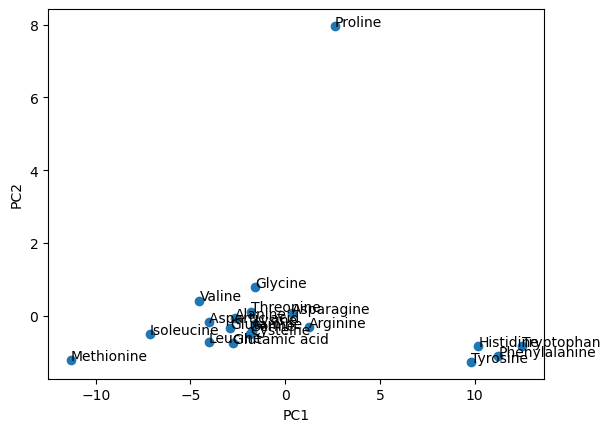

In [109]:
plt.scatter(vec_pca[:,0], vec_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_pca[i,0], vec_pca[i,1]))

In [110]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5)

In [111]:
tsne_componets = tsne.fit_transform(encoded)

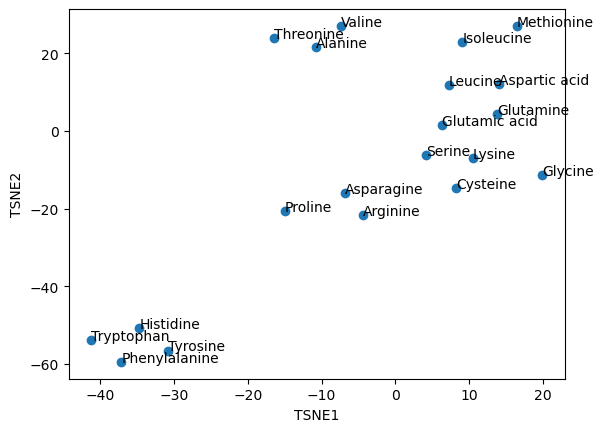

In [112]:
plt.scatter(tsne_componets[:,0], tsne_componets[:,1])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
for i, txt in enumerate(names):
    plt.annotate(txt, (tsne_componets[i,0], tsne_componets[i,1]))

In [113]:
aa_map = {name:smile for name, smile in zip(names, aa_smiles)}

In [114]:
aa_map['Leucine']

'CC(C)CC(C(=O)O)N'

In [115]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)

In [116]:
tanimoto_similarity(aa_map['Leucine'], aa_map['Isoleucine'])

0.4230769230769231

In [117]:
encoded_leucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Leucine'])])).float().to(device))
encoded_leucine = encoded_leucine.cpu().detach().numpy()[0]
encoded_isoleucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Isoleucine'])])).float().to(device))
encoded_isoleucine = encoded_isoleucine.cpu().detach().numpy()[0]

In [118]:
from scipy.spatial.distance import cosine, euclidean

In [119]:
print(f'Tanimoto distance: {tanimoto_similarity(aa_map["Leucine"], aa_map["Isoleucine"])}')
print(f'Cosine distance: {cosine(encoded_leucine, encoded_isoleucine)}')
print(f'Euclidean distance: {euclidean(encoded_leucine, encoded_isoleucine)}')

Tanimoto distance: 0.4230769230769231
Cosine distance: 0.00931692123413086
Euclidean distance: 4.222630977630615


In [120]:
results = {'Name':[], 'Tanimoto':[], 'Cosine':[], 'Euclidean':[]}
for name, smile in aa_map.items():
    encoded = encoder(torch.from_numpy(np.array([get_fingerprint(smile)])).float().to(device))
    encoded = encoded.cpu().detach().numpy()[0]
    results['Name'].append(name)
    results['Tanimoto'].append(tanimoto_similarity(aa_map['Leucine'], smile))
    results['Cosine'].append(1 - cosine(encoded_leucine, encoded))
    results['Euclidean'].append(euclidean(encoded_leucine, encoded))
df = pd.DataFrame(results).sort_values(by='Tanimoto', ascending=False)

In [121]:
df

,Name,Tanimoto,Cosine,Euclidean
10,Leucine,1.000000,1.000000,0.000000
3,Aspartic acid,0.545455,0.997047,1.388521
2,Asparagine,0.521739,0.989630,4.874411
15,Serine,0.500000,0.996626,2.666071
0,Alanine,0.500000,0.984807,3.256508
4,Cysteine,0.478261,0.986585,3.466704
12,Methionine,0.444444,0.994919,7.721180
5,Glutamic acid,0.440000,0.997497,1.770815
19,Valine,0.434783,0.970169,4.628265
6,Glutamine,0.423077,0.995568,1.945615


In [122]:
no_target = df[df['Name'] != 'Leucine']
print(f'Most similar in Tanimoto: {no_target.sort_values(by="Tanimoto", ascending=False).iloc[0,0]}')
print(f'Most similar in Cosine: {no_target.sort_values(by="Cosine", ascending=False).iloc[0,0]}')
print(f'Most similar in Euclidean: {no_target.sort_values(by="Euclidean", ascending=True).iloc[0,0]}')

Most similar in Tanimoto: Aspartic acid
Most similar in Cosine: Glutamic acid
Most similar in Euclidean: Aspartic acid


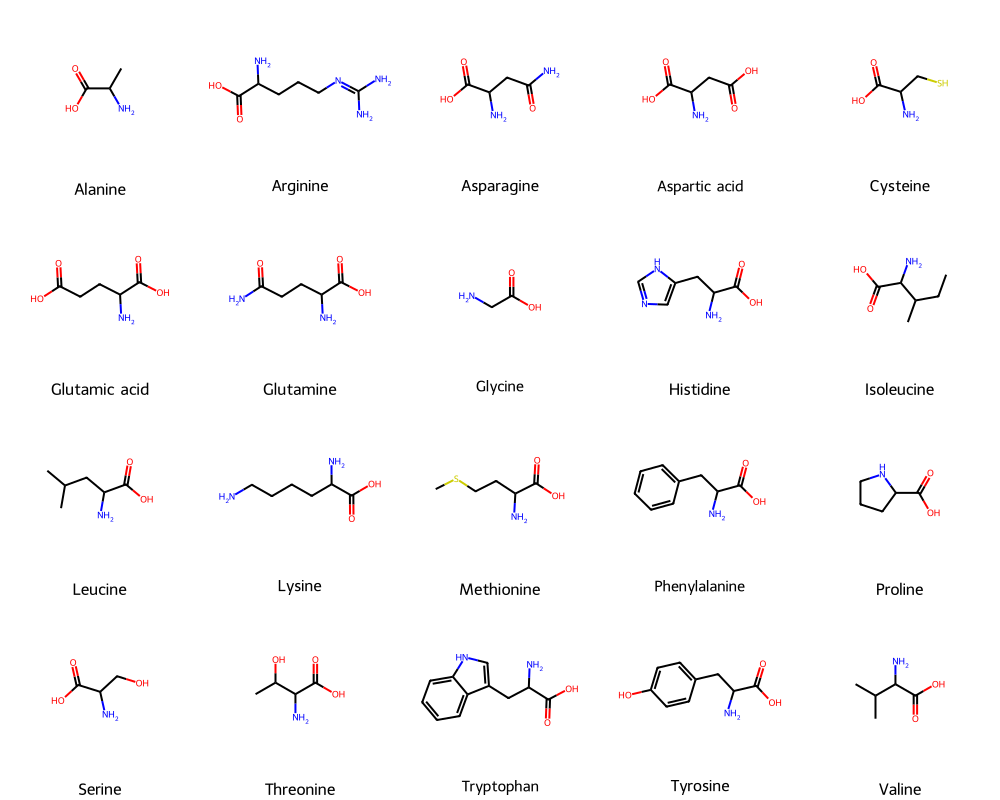

In [62]:
from rdkit.Chem import Draw
# draw all amino acids
mols = [Chem.MolFromSmiles(smile) for smile in aa_smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=names)

In [63]:
# get substructure matches
from rdkit.Chem import rdFMCS
leucine = Chem.MolFromSmiles(aa_map['Leucine'])
glu = Chem.MolFromSmiles(aa_map['Glutamic acid'])
aspartic_acid = Chem.MolFromSmiles(aa_map['Aspartic acid'])
mcs = rdFMCS.FindMCS([leucine, glu, aspartic_acid], ringMatchesRingOnly=True, completeRingsOnly=True)
mcs = Chem.MolFromSmarts(mcs.smartsString)

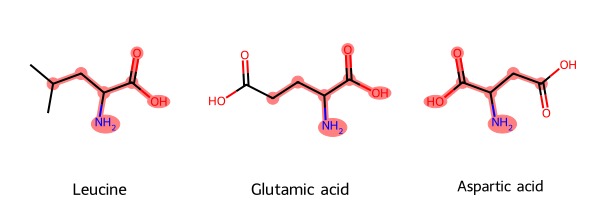

In [64]:
# draw substructure matches
Draw.MolsToGridImage([leucine, glu, aspartic_acid], molsPerRow=3, subImgSize=(200,200), highlightAtomLists=[leucine.GetSubstructMatch(mcs), glu.GetSubstructMatch(mcs), aspartic_acid.GetSubstructMatch(mcs)], legends=['Leucine', 'Glutamic acid', 'Aspartic acid'])